## Import libraries

In [1]:
# standard library imports
import pandas as pd
import numpy as np
import sklearn

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import optuna

from optuna.visualization.matplotlib import plot_param_importances

import mlflow

# client = mlflow.MlflowClient(tracking_uri='http://127.0.0.1:8080')

from sklearn.model_selection import cross_val_score


from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline as skl_pipeline

from imblearn.pipeline import Pipeline as imb_pipeline
from imblearn.over_sampling import SMOTE

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer

sklearn.set_config(transform_output='pandas')

# load scalers
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler

# load metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.metrics import roc_curve
from sklearn.metrics import PredictionErrorDisplay

pd.set_option('display.float_format', '{:.3f}'.format)



# константы
RAND_ST = 345


In [2]:
import sklearn
sklearn.__version__

'1.3.2'

## Import dataset

In [3]:

df = pd.read_csv('datasets/transport.csv')
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   distance             1572 non-null   int64
 1   own_container        1572 non-null   int64
 2   complect_send        1572 non-null   int64
 3   container_train      1572 non-null   int64
 4   transportation_type  1572 non-null   int64
 5   days                 1572 non-null   int64
 6   price                1572 non-null   int64
dtypes: int64(7)
memory usage: 86.1 KB


,distance,own_container,complect_send,container_train,transportation_type,days,price
0,2808,0,1,0,3,12,26497
1,4102,0,0,0,3,18,45948
2,1211,0,1,0,3,7,152484
3,2836,0,1,0,3,10,176701
4,2808,0,1,0,3,10,176525


## EDA

In [4]:
display(df.isna().sum(), df.nunique(), df.describe())


distance               0
own_container          0
complect_send          0
container_train        0
transportation_type    0
days                   0
price                  0
dtype: int64

distance               536
own_container            2
complect_send            2
container_train          2
transportation_type      4
days                    35
price                  765
dtype: int64

,distance,own_container,complect_send,container_train,transportation_type,days,price
count,1572.000,1572.000,1572.000,1572.000,1572.000,1572.000,1572.000
mean,4732.854,0.034,0.367,0.272,2.772,16.492,176175.534
std,2147.144,0.181,0.482,0.445,0.636,6.440,871625.834
min,18.000,0.000,0.000,0.000,1.000,4.000,1000.000
25%,3684.000,0.000,0.000,0.000,3.000,12.000,48151.000
50%,4307.000,0.000,0.000,0.000,3.000,17.000,144243.000
75%,4951.250,0.000,1.000,1.000,3.000,19.000,179355.250
max,10645.000,1.000,1.000,1.000,4.000,41.000,33800995.000


       distance  own_container  complect_send  container_train  \
count  1571.000       1571.000       1571.000         1571.000   
mean   4733.255          0.034          0.367            0.272   
std    2147.768          0.181          0.482            0.445   
min      18.000          0.000          0.000            0.000   
25%    3684.000          0.000          0.000            0.000   
50%    4311.000          0.000          0.000            0.000   
75%    4951.500          0.000          1.000            1.000   
max   10645.000          1.000          1.000            1.000   

       transportation_type     days       price  
count             1571.000 1571.000    1571.000  
mean                 2.771   16.491  154772.085  
std                  0.636    6.442  199026.556  
min                  1.000    4.000    1000.000  
25%                  3.000   12.000   48151.000  
50%                  3.000   17.000  144227.000  
75%                  3.000   19.000  179063.500  
max  

<Axes: ylabel='price'>

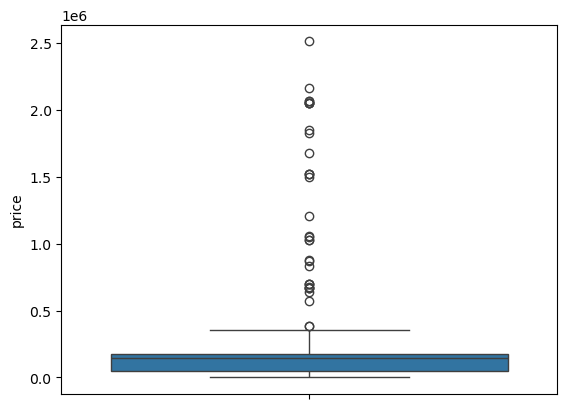

In [5]:
df = df[df['price'] < 33800995.000]
print(df.describe())
sns.boxplot(df['price'])

In [6]:
df[df['price'] > 300000].sort_values('price', ascending=False)

# сколько контейнеров, объем контейнера. вес контейнера, расчет с привязкой к валюте или еще чему то, ценность груза, вид контейнера - холодильник, цистерна дрр

,distance,own_container,complect_send,container_train,transportation_type,days,price
594,9274,0,0,1,3,22,2510946
1458,10388,0,0,1,3,21,2162284
916,9416,0,0,1,1,23,2067167
701,9416,0,0,1,1,23,2067167
915,9278,0,0,1,1,22,2050353
704,9278,0,0,1,1,22,2050353
917,9263,0,0,1,1,22,2048400
703,9263,0,0,1,1,22,2048400
72,9416,0,0,1,1,23,1848431
70,9263,0,0,1,1,22,1829664


In [7]:
df[df['price'] > 300000][['distance', 'days', 'price']].corr()

,distance,days,price
distance,1.000,0.719,0.641
days,0.719,1.000,0.277
price,0.641,0.277,1.000


In [8]:
df = df[df['price'] < 300000]
df.describe()

,distance,own_container,complect_send,container_train,transportation_type,days,price
count,1534.000,1534.000,1534.000,1534.000,1534.000,1534.000,1534.000
mean,4684.228,0.026,0.376,0.257,2.788,16.439,129739.551
std,2115.117,0.159,0.485,0.437,0.609,6.410,64042.769
min,18.000,0.000,0.000,0.000,1.000,4.000,1000.000
25%,3610.500,0.000,0.000,0.000,3.000,12.000,45948.000
50%,4290.000,0.000,0.000,0.000,3.000,17.000,141916.000
75%,4905.000,0.000,1.000,1.000,3.000,18.000,176707.750
max,10645.000,1.000,1.000,1.000,4.000,41.000,295637.000


## Split df to train and test

In [9]:
X, y = df.drop('price', axis=1), df['price']

# split df into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=RAND_ST)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1150, 6) (1150,) (384, 6) (384,)


In [10]:
# X_train = X_train.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)
# X_train
# y_train

In [11]:
X.select_dtypes(exclude='object').columns

Index(['distance', 'own_container', 'complect_send', 'container_train',
       'transportation_type', 'days'],
      dtype='object')

## Violinplot for num col

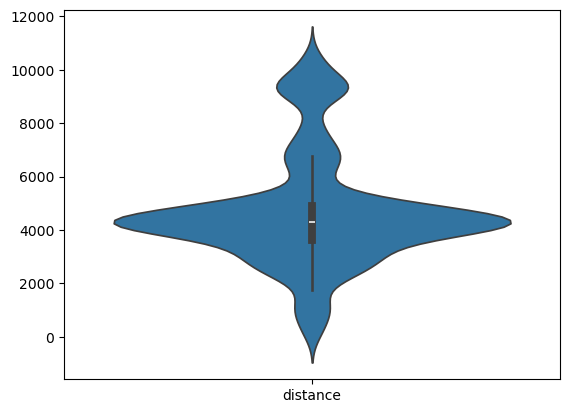

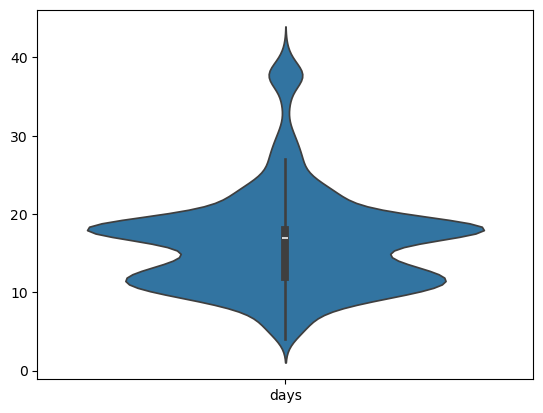

In [12]:
num_col = ['distance', 'days']

for i in df[num_col]:
    sns.violinplot(data = df[[i]])
    plt.show()

## Make pipeline

In [13]:

    num_col = ['distance', 'days']

    cat_col = ['own_container', 'complect_send', 'container_train',
        'transportation_type']
    # transformer for numeric col
    num_transformer = skl_pipeline(
        steps=[
            #transform
            (
                'power',
                PowerTransformer()
            )
        ]
    )


    # transformer for categorical col
    cat_transformer = skl_pipeline(
        steps=[
            (
                'ohe',
                OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False) # drop = 'if_binary' if cat will not change
            )
        ]
    )


    # make preprocessor
    preprocessor = ColumnTransformer(
        remainder='passthrough',
        transformers=[
            ('num_transformer', num_transformer, num_col),
            ('cat_transformer', cat_transformer, cat_col)
        ]
    )

    # make pipe model
    pipe_xgbr = skl_pipeline(steps=[
        
        (
            'preprocessor',
            preprocessor
        ),
        #model
        (
            'model_xgbr',
            xgb.XGBRegressor(random_state=RAND_ST)
        )
    ])

In [14]:
preprocessor.fit(X_train, y_train)
preprocessor.transform(X_train)

,num_transformer__distance,num_transformer__days,cat_transformer__own_container_1,cat_transformer__complect_send_1,cat_transformer__container_train_1,cat_transformer__transportation_type_2,cat_transformer__transportation_type_3,cat_transformer__transportation_type_4
582,-2.754,-1.378,0.000,0.000,1.000,0.000,1.000,0.000
1014,-0.188,0.398,0.000,0.000,0.000,0.000,1.000,0.000
365,-0.626,-0.882,0.000,1.000,0.000,0.000,1.000,0.000
370,-0.598,-0.882,0.000,1.000,0.000,0.000,1.000,0.000
890,-0.188,0.398,0.000,0.000,0.000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...
571,1.089,2.417,0.000,0.000,0.000,1.000,0.000,0.000
419,0.004,-0.086,0.000,1.000,0.000,0.000,1.000,0.000
675,-0.868,-0.882,0.000,0.000,1.000,0.000,1.000,0.000
213,-1.060,-1.120,0.000,1.000,0.000,0.000,1.000,0.000


## Hyperparameter tuning

In [15]:
# add hyper from tree 


def hyper_opt(trial):
    parameters_xgbr = {
        'model_xgbr__learning_rate': trial.suggest_float('model_xgbr__learning_rate', 0.01, 0.6), # alias for eta
        'model_xgbr__min_split_loss': trial.suggest_int ('model_xgbr__min_split_loss', 0, 250000),    # alias for gamma
        'model_xgbr__max_depth': trial.suggest_int('model_xgbr__max_depth', 1, 100),
        'model_xgbr__min_child_weight': trial.suggest_int('model_xgbr__min_child_weight', 1, 20),
        'model_xgbr__subsample': trial.suggest_float('model_xgbr__subsample', 0.5, 1),
        'model_xgbr__colsample_bytree': trial.suggest_float('model_xgbr__colsample_bytree', 0.5, 1),
        'model_xgbr__reg_lambda': trial.suggest_int('model_xgbr__reg_lambda', 0, 200),
        'model_xgbr__reg_alpha': trial.suggest_int('model_xgbr__reg_alpha', 0, 100),    #???
        'model_xgbr__n_estimators': trial.suggest_int('model_xgbr__n_estimators', 5, 2000),
        'model_xgbr__max_leaves': trial.suggest_int('model_xgbr__max_leaves', 2, 100)
    }
    
    num_col = ['distance', 'days']

    cat_col = ['own_container', 'complect_send', 'container_train',
        'transportation_type']
    # transformer for numeric col
    num_transformer = skl_pipeline(
        steps=[
            #transform
            (
                'power',
                PowerTransformer()
            )
        ]
    )


    # transformer for categorical col
    cat_transformer = skl_pipeline(
        steps=[
            (
                'ohe',
                OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)
            )
        ]
    )


    # make preprocessor
    preprocessor = ColumnTransformer(
        remainder='passthrough',
        transformers=[
            ('num_transformer', num_transformer, num_col),
            ('cat_transformer', cat_transformer, cat_col)
        ]
    )

    # make pipe model
    pipe_xgbr = skl_pipeline(steps=[
        
        (
            'preprocessor',
            preprocessor
        ),
        #model
        (
            'model_xgbr',
            xgb.XGBRegressor(random_state=RAND_ST)
        )
    ])

    pipe_xgbr.set_params(**parameters_xgbr) #разименование
    
    return cross_val_score(pipe_xgbr, X_train, y_train, scoring='neg_mean_squared_error').mean() #neg mse???
    # pipe_xgbr.fit(X_train, y_train)
    # print(mean_squared_error(pipe_xgbr.predict(X_train), y_train))
    # return mean_squared_error(pipe_xgbr.predict(X_train), y_train)
    

In [16]:
study = optuna.create_study(direction='maximize') #maximize
study.optimize(hyper_opt, n_trials=100)

[I 2023-11-30 18:24:56,402] A new study created in memory with name: no-name-4b76356c-03d0-4618-b24b-caa5a4f39466
[I 2023-11-30 18:24:58,276] Trial 0 finished with value: -875132657.676595 and parameters: {'model_xgbr__learning_rate': 0.5526053835040189, 'model_xgbr__min_split_loss': 240235, 'model_xgbr__max_depth': 60, 'model_xgbr__min_child_weight': 20, 'model_xgbr__subsample': 0.5004785047674172, 'model_xgbr__colsample_bytree': 0.601710121122664, 'model_xgbr__reg_lambda': 37, 'model_xgbr__reg_alpha': 66, 'model_xgbr__n_estimators': 509, 'model_xgbr__max_leaves': 7}. Best is trial 0 with value: -875132657.676595.
[I 2023-11-30 18:25:02,595] Trial 1 finished with value: -769282401.8806698 and parameters: {'model_xgbr__learning_rate': 0.45976867443420477, 'model_xgbr__min_split_loss': 71343, 'model_xgbr__max_depth': 72, 'model_xgbr__min_child_weight': 17, 'model_xgbr__subsample': 0.8276677818625111, 'model_xgbr__colsample_bytree': 0.7070172326222588, 'model_xgbr__reg_lambda': 44, 'mode

{'model_xgbr__learning_rate': 0.09243325994373155, 'model_xgbr__min_split_loss': 96979, 'model_xgbr__max_depth': 42, 'model_xgbr__min_child_weight': 1, 'model_xgbr__subsample': 0.729618257582194, 'model_xgbr__colsample_bytree': 0.9977248657932921, 'model_xgbr__reg_lambda': 190, 'model_xgbr__reg_alpha': 29, 'model_xgbr__n_estimators': 1813, 'model_xgbr__max_leaves': 23}


/tmp/ipykernel_41012/1373939319.py:3: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study);


-617974405.4456784

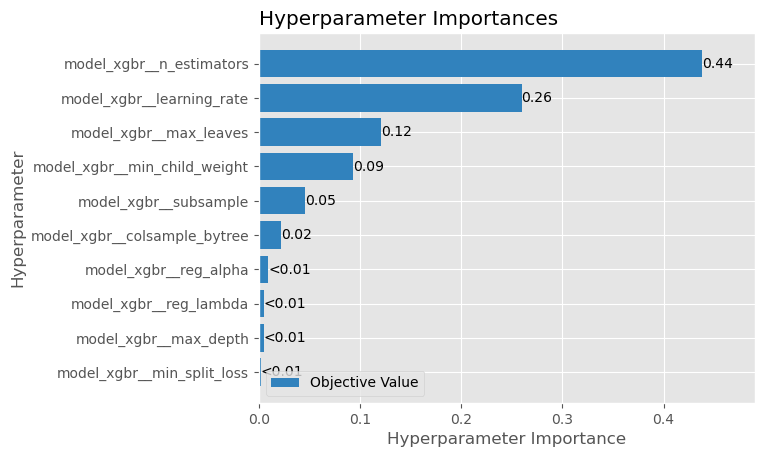

In [17]:
print(study.best_params)

plot_param_importances(study);
study.best_value

In [18]:
pipe_xgbr.set_params(**study.best_params)
pipe_xgbr.fit(X_train, y_train)
pd.DataFrame(pipe_xgbr.predict(X_train)).describe()
mean_squared_error(y_train, pipe_xgbr.predict(X_train))/y_train.shape
mean_absolute_error(y_train, pipe_xgbr.predict(X_train))/y_train.shape

array([7.20956603])

## Mlflow model save

In [ ]:
# start server 
mlflow.set_tracking_uri='http://127.0.0.1:5000'

In [19]:
# Set our tracking server uri for logging
# mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("XGBR 4")

2023/11/30 18:46:39 INFO mlflow.tracking.fluent: Experiment with name 'XGBR 4' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/pmu/zet/obs-h/Skills/Data%20Science/Data%20Scientist%20Full-Stack/exercises/practice/mlruns/555592421686817878', creation_time=1701359199067, experiment_id='555592421686817878', last_update_time=1701359199067, lifecycle_stage='active', name='XGBR 4', tags={}>

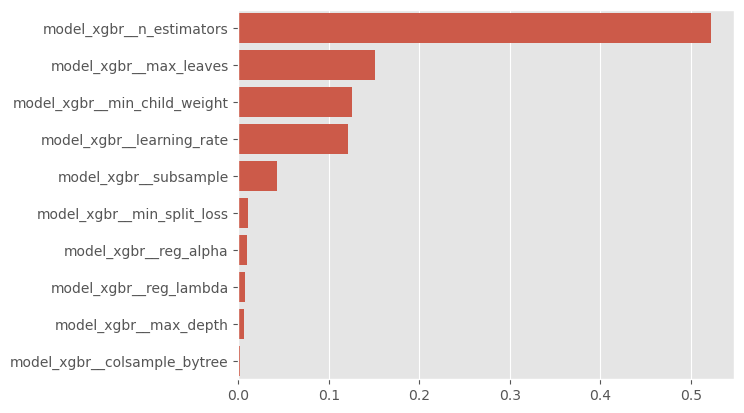

In [20]:
hyperparams = optuna.importance.get_param_importances(study)
sns.barplot(y=hyperparams.keys(), x=hyperparams.values())
plt.savefig('hyperparams.png')

In [32]:
len(y_train) * 0.8

920.0

In [21]:
# Start an MLflow run
with mlflow.start_run(run_name='xgbr_price_2000_estimate_max_lives'):
    # Log the hyperparameters
    mlflow.log_params(study.best_params)
    pipe_xgbr.set_params(**study.best_params)
    pipe_xgbr.fit(X_train, y_train)
    predict_test  = pipe_xgbr.predict(X_test)
    metrics = {
        'mse_cv':study.best_value / len(y_train) * 0.8, # if cv = 5
        'mae': mean_absolute_error(y_test, predict_test) / len(y_test),
        'median_abs_error': abs(y_test - predict_test).median(),
        'mean_abs_error': abs(y_test - predict_test).mean(),
        'median_error': (abs(y_test - predict_test)/ y_test).median(),
        'mean_error': (abs(y_test - predict_test) / y_test).mean()
    } 
    mlflow.log_artifact('hyperparams.png') 
    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(pipe_xgbr, 'xgbr_price_2000_estimate_max_lives')

In [51]:
# # mlflow.create_experiment('predict_price')
# with mlflow.start_run():
#     mlflow.log_params(study.best_params)
#     mlflow.log_metric('mse', study.best_value)

#     pipe_xgbr.set_params(**study.best_params)
#     pipe_xgbr.fit(X_train, y_train)
#     mlflow.sklearn.log_model(pipe_xgbr, 'xgbr_price')

In [22]:

mean_absolute_error(y_train, pipe_xgbr.predict(X_train)) / y_train.shape

array([7.14498313])

# Model analysis

In [48]:
print(f'RMSE = {mean_squared_error(y_test, pipe_xgbr.predict(X_test), squared=False) / y_test.shape}')
print(f'MAE = {mean_absolute_error(y_test, pipe_xgbr.predict(X_test)) / y_test.shape}')

RMSE = [74.76041428]
MAE = [36.13490354]


0.1370808551662202 0.019634131038148105


<Axes: >

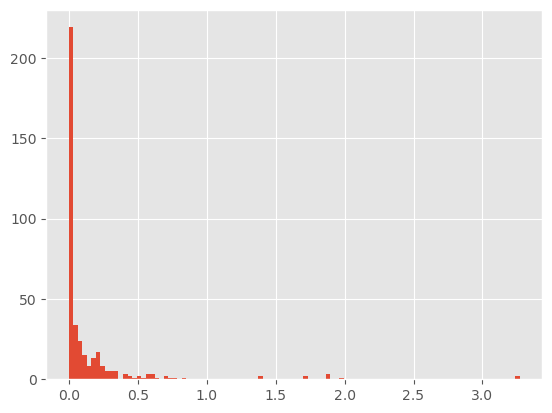

In [49]:
error_abs = (abs(pipe_xgbr.predict(X_test) - y_test)) / y_test
print(error_abs.mean(), error_abs.median())
error_abs.hist(bins=100)

In [50]:
(pd.DataFrame(pipe_xgbr.predict(X_test))).describe()

,0
count,384.000
mean,133853.203
std,59761.625
min,16598.471
25%,77931.312
50%,146911.938
75%,173687.812
max,285859.094


array([[<Axes: title={'center': '0'}>]], dtype=object)

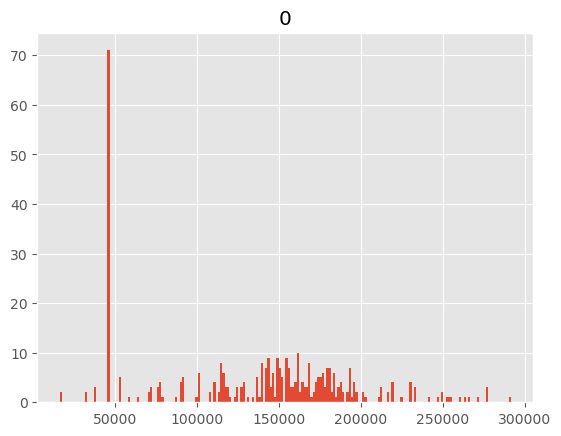

In [43]:
(pd.DataFrame(pipe_xgbr.predict(X_test))).hist(bins=200)

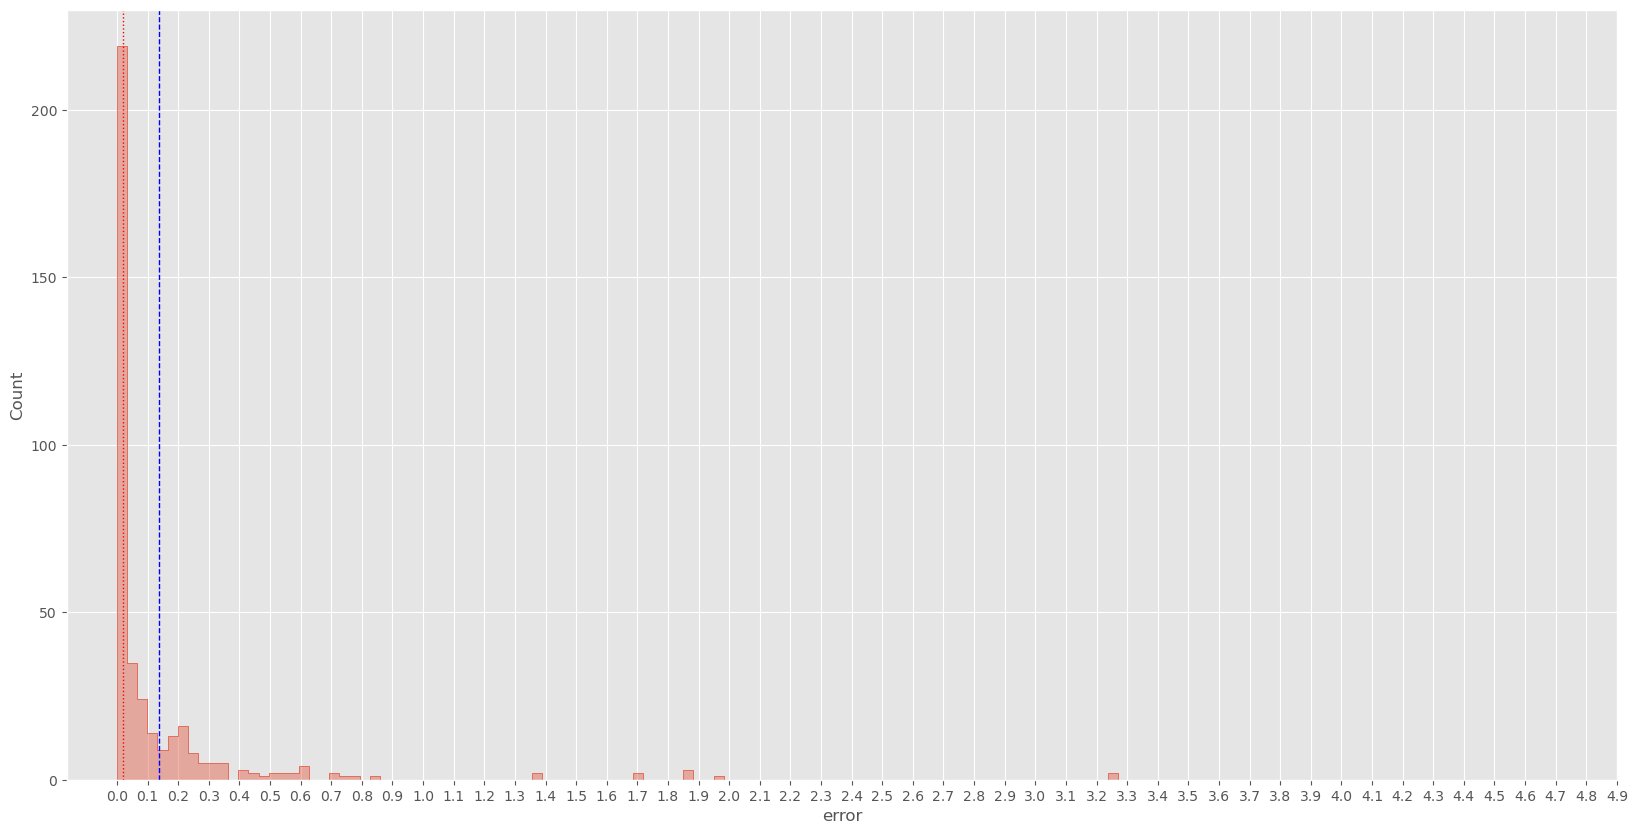

In [38]:
abs_error = abs(y_test - pipe_xgbr.predict(X_test)) / y_test


# sns mean + median  mlflow fig 

plt.figure(figsize=(20, 10))
sns.histplot(abs_error, alpha=0.4,  element="step")
plt.xticks(np.arange(0, 5, 0.1))
plt.axvline(x=abs_error.mean(), color='b', ls='--', lw=1, label='Mean value of abs error')
plt.axvline(x=abs_error.median(), color='r', ls=':', lw=1, label='Median value of abs error')
plt.xlabel('error')
plt.show()

<Axes: ylabel='price'>

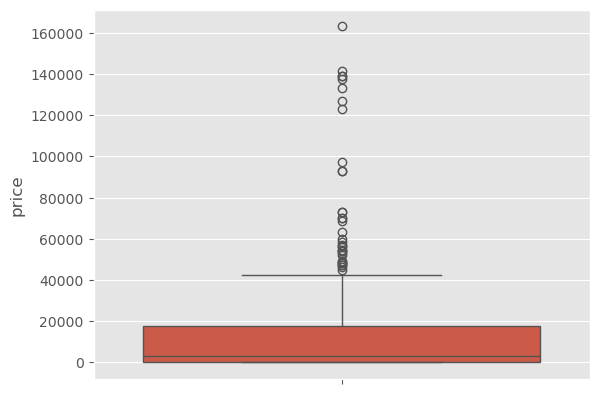

In [39]:
sns.boxplot(pd.Series(abs(y_test - pipe_xgbr.predict(X_test))))

In [40]:
pipe_xgbr.predict(X_test)

array([178243.62 , 169331.5  ,  36421.527, 148916.28 , 129255.13 ,
       188997.73 , 137058.22 , 114826.24 , 223873.95 ,  89679.37 ,
       139568.39 , 223873.95 ,  45955.902, 182308.39 , 117647.04 ,
       192694.77 , 176160.19 , 178307.66 , 148111.19 , 180285.69 ,
        45955.902, 183149.66 ,  45955.902,  45955.902, 147692.72 ,
       262233.5  , 192993.7  , 278347.8  ,  45955.902, 150913.84 ,
       161862.94 ,  77508.8  ,  45955.902, 152234.8  ,  45955.902,
       183137.53 ,  45955.902, 151052.84 ,  45955.902, 223873.95 ,
       119791.84 , 192993.7  ,  45955.902, 150682.1  , 119830.01 ,
       114590.65 , 197237.97 , 119830.01 ,  45955.902,  45955.902,
       240510.88 , 150850.45 ,  45955.902, 248785.55 ,  45955.902,
       174281.08 , 123327.77 , 117647.04 , 240510.88 , 115835.875,
        45955.902, 211200.92 ,  45955.902, 255336.86 ,  45955.902,
        16598.47 , 192034.78 , 230645.39 , 177093.95 , 139815.   ,
        45955.902, 255930.77 , 187901.98 , 218960.75 , 132482.

## Importances

In [41]:
pipe_xgbr['model_xgbr'].feature_importances_

array([0.12555566, 0.11960369, 0.07498579, 0.33604082, 0.12177146,
       0.05377368, 0.14676566, 0.02150329], dtype=float32)

In [42]:
pipe_xgbr['preprocessor'].get_feature_names_out()

array(['num_transformer__distance', 'num_transformer__days',
       'cat_transformer__own_container_1',
       'cat_transformer__complect_send_1',
       'cat_transformer__container_train_1',
       'cat_transformer__transportation_type_2',
       'cat_transformer__transportation_type_3',
       'cat_transformer__transportation_type_4'], dtype=object)

In [43]:
importance = pd.DataFrame({
    'name': pipe_xgbr['preprocessor'].get_feature_names_out(), 
    'importance': pipe_xgbr['model_xgbr'].feature_importances_
})

In [44]:
importance.sort_values('importance', ascending=False, inplace=True)

<Axes: xlabel='importance', ylabel='name'>

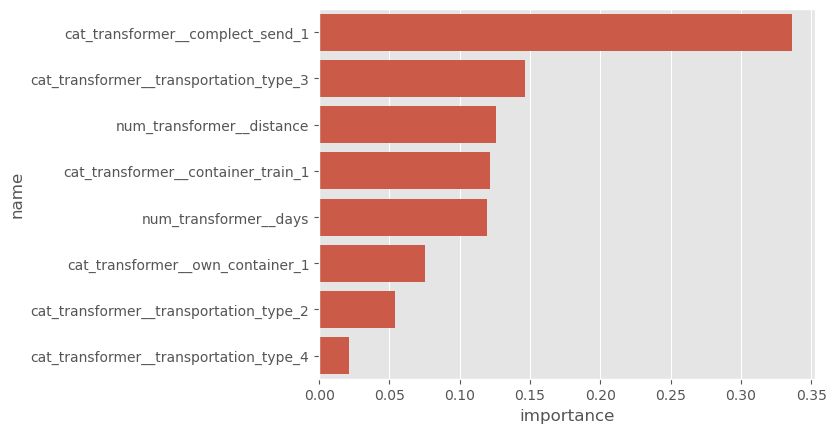

In [45]:
sns.barplot(data=importance, y='name', x='importance')